In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [51]:
#Download the dataset
dataframe=pd.read_csv('data/ecg.csv',header=None)
raw_data=dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [52]:
#最后一个元素为标签，要么为0（异常），要么为1（正常）
labels=raw_data[:,-1]
#其他的点是心电图数据
data=raw_data[:,0:-1]
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=0.2,random_state=21)

In [53]:
#将数据标准化为0-1之间的数。此处使用的是线性归一化算法。
min_val=tf.reduce_min(train_data)#求最小值
max_val=tf.reduce_max(train_data)#求最大值https://blog.csdn.net/nanhuaibeian/article/details/100591478?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromBaidu-1.not_use_machine_learn_pai&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromBaidu-1.not_use_machine_learn_pai
train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)
train_data=tf.cast(train_data,tf.float32)#将张量转换为f32类型
test_data=tf.cast(test_data,tf.float32)
test_data.dtype

tf.float32

In [54]:
#下面只使用正常数据训练AE，这些数据的标签为1，从异常数据中分出正常的数据点
trian_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)

normal_train_data = train_data[train_labels==True]
normal_test_data = test_data[test_labels==True]

anomalous_train_data = train_data[train_labels==False]
anomalous_test_data = test_data[test_labels==False]
normal_test_data

<tf.Tensor: shape=(560, 140), dtype=float32, numpy=
array([[0.48035768, 0.28877792, 0.19828546, ..., 0.45463306, 0.5246125 ,
        0.3713729 ],
       [0.45354807, 0.2557325 , 0.15979648, ..., 0.4801337 , 0.5284734 ,
        0.49527124],
       [0.4521779 , 0.25685105, 0.12592098, ..., 0.55448556, 0.5861353 ,
        0.4754273 ],
       ...,
       [0.48304972, 0.36122933, 0.27729514, ..., 0.32799056, 0.3158066 ,
        0.26930442],
       [0.4090865 , 0.27907097, 0.22604261, ..., 0.39099607, 0.45987615,
        0.42140076],
       [0.42648116, 0.17669384, 0.14546008, ..., 0.4733389 , 0.55036914,
        0.37805188]], dtype=float32)>

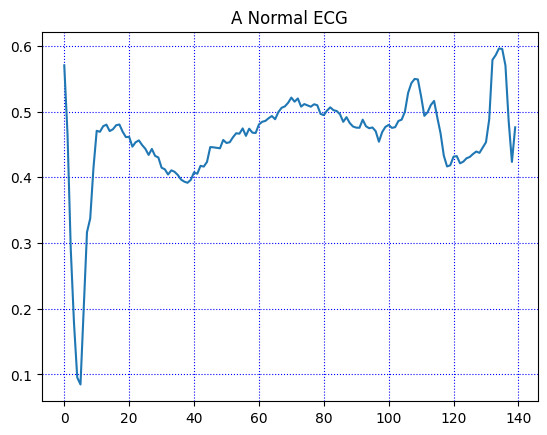

In [55]:
#画出正常的ECG
plt.grid(linestyle=":",color="b")#绘制刻度线的网格线
plt.plot(np.arange(140),normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

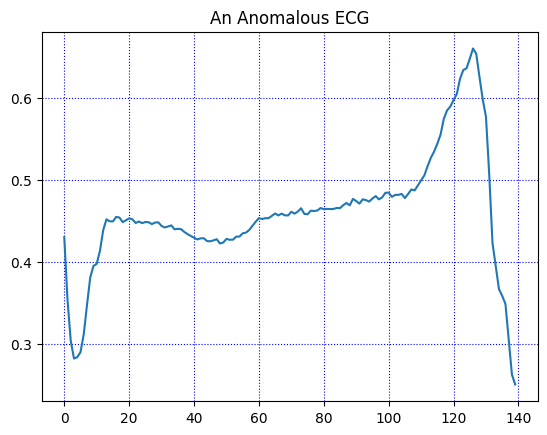

In [56]:
#画出异常的ECG
plt.grid(linestyle=":",color="b")
plt.plot(np.arange(140),anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

In [57]:
#训练模型
class AnomalyDetector(Model):
    def __init__(self):
        #建立神经网络
        super(AnomalyDetector,self).__init__()
        self.encoder=tf.keras.Sequential([layers.Dense(32,activation="relu"),layers.Dense(16,activation="relu"),layers.Dense(8,activation="relu")])
         #建立神经网络
        self.decoder=tf.keras.Sequential([
          layers.Dense(16, activation="relu"),
          layers.Dense(32, activation="relu"),
          layers.Dense(140, activation="sigmoid")])
    def call(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(x)
        return decoded
autoencoder=AnomalyDetector()
#compile用于配置训练的模型优化器为adam算法，损失函数为mae
#compile
#(
#    optimizer='rmsprop',
#    loss=None,
 #   metrics=None,
  #  loss_weights=None,
   # sample_weight_mode=None,
    #weighted_metrics=None,
    #target_tensors=None,
    #distribute=None,
    #**kwargs
#)optimizer - 用来配置模型的优化器，可以调用tf.keras.optimizers API配置模型所需要的优化器。
#loss - 用来配置模型的损失函数，可以通过名称调用tf.losses API中已经定义好的loss函数。
#metrics - 用来配置模型评价的方法，如accuracy、mse等。
autoencoder.compile(optimizer='adam',loss='mae')#compile函数编译模型优化器为adam算法，损失函数为mean_absolute_error

In [58]:
#这编码器只使用了正常心电图数据来训练，但是用所有的测试集来评估
history=autoencoder.fit(normal_train_data,normal_train_data,epochs=20,batch_size=512,
                       validation_data=(test_data,test_data),shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0623 - val_loss: 0.0567
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0546 - val_loss: 0.0511
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0491
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0464 - val_loss: 0.0469
Epoch 5/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0422 - val_loss: 0.0451
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0386 - val_loss: 0.0442
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0356 - val_loss: 0.0428
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0329 - val_loss: 0.0414
Epoch 9/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0308 - val_loss: 0.0407
Epoch 10/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0292 - val_loss: 0.0401
Epoch 11/20
5/5 [=====================

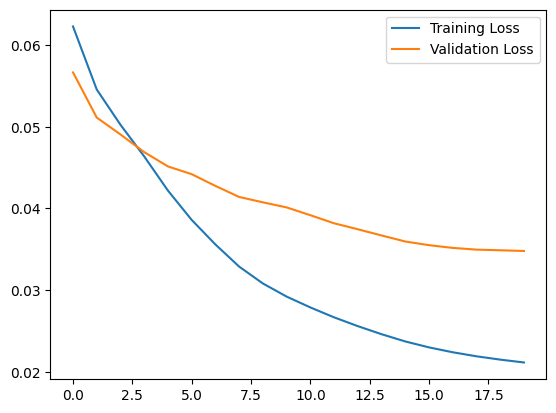

In [59]:
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()

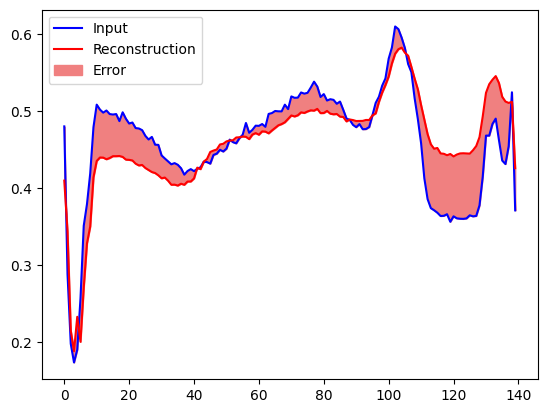

array([[0.67532676, 0.        , 0.41994247, ..., 0.        , 0.35752007,
        0.37827688],
       [0.69042975, 0.01137694, 0.40952292, ..., 0.        , 0.30733582,
        0.32797012],
       [0.7408531 , 0.0329848 , 0.50217086, ..., 0.        , 0.31431785,
        0.31358984],
       ...,
       [0.6738399 , 0.00434861, 0.38206577, ..., 0.        , 0.32332325,
        0.36167508],
       [0.6586945 , 0.02002764, 0.35681114, ..., 0.        , 0.2908618 ,
        0.35959077],
       [0.675882  , 0.        , 0.4038793 , ..., 0.        , 0.3119962 ,
        0.3551624 ]], dtype=float32)

In [60]:
#如果重构误差大于正常训练示例的一个标准偏差，您将很快将ECG归类为异常。 首先，让我们从训练集中绘制正常的ECG，通过自动编码器进行编码和解码后的重构以及重构误差。
encoded_imgs=autoencoder.encoder(normal_test_data).numpy()
decoded_imgs=autoencoder.decoder(normal_test_data).numpy()
plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140),decoded_imgs[0],normal_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()
encoded_imgs

In [61]:
#画出异常的测试样例
encoded_imgs=autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs=autoencoder.decoder(anomalous_test_data).numpy()

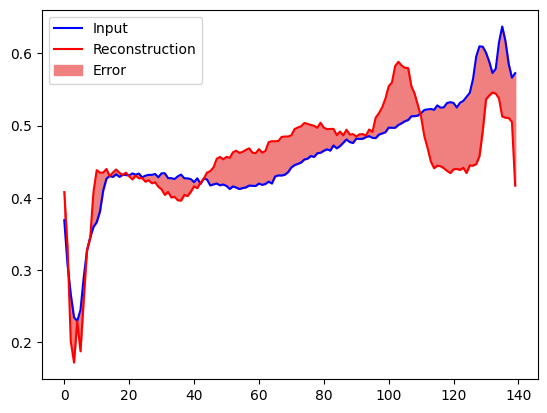

In [62]:
plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140),decoded_imgs[0],anomalous_test_data[0],color='lightcoral')
plt.legend(labels=["Input","Reconstruction","Error"])
plt.show()

In [63]:
#通过检测计算重构损失是否大于一个固定的阈值来检测异常，在本教程中先从训练集中计算每个正常样本的平均误差
#然后，如果重构误差比来自训练集的标准偏差还要高那么就将这个样本确定为异常
#画出来自训练集的正常ECGs的重构误差
reconstructions=autoencoder.predict(normal_train_data)#predict为输入样本生成输出预测，样本属于每个类别的概率，这里是0（异常），1（正常）。计算是分批进行的，返回预测的 Numpy 数组（或数组列表）。
reconstructions

74/74 [==============================] - 0s 519us/step


array([[0.4108677 , 0.34266663, 0.21454695, ..., 0.50882876, 0.50969416,
        0.42302722],
       [0.41322246, 0.34037262, 0.21416225, ..., 0.5088062 , 0.51244503,
        0.42176118],
       [0.40914607, 0.33761463, 0.20784459, ..., 0.5116153 , 0.51081663,
        0.42122948],
       ...,
       [0.40986216, 0.34008893, 0.21065411, ..., 0.5119362 , 0.5132546 ,
        0.4234428 ],
       [0.4116984 , 0.33862862, 0.2104834 , ..., 0.51153725, 0.51318103,
        0.42195612],
       [0.41003495, 0.33643782, 0.20725739, ..., 0.51163536, 0.51048774,
        0.42080328]], dtype=float32)

In [64]:
train_loss=tf.keras.losses.mae(reconstructions,normal_train_data).numpy()
train_loss

array([0.02666162, 0.01230181, 0.02052883, ..., 0.01351059, 0.02341199,
       0.01704854], dtype=float32)

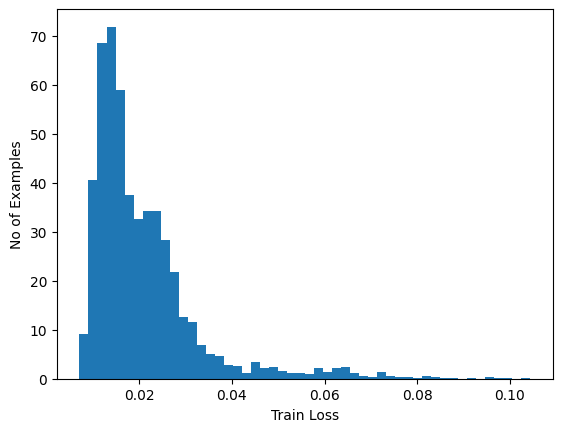

In [65]:
plt.hist(train_loss,bins=50,density=True)#直方图
plt.xlabel("Train Loss")
plt.ylabel("No of Examples")
plt.show()

In [66]:
#选择比平均值高一个标准偏差的阈值。这里选择阈值的方法取决于数据集。
threshold=np.mean(train_loss)+np.std(train_loss)
print("Threshold",threshold)

Threshold 0.03328122


In [67]:
#当检测测试集中的异常样本的重构误差的时候，大部分样本的重构误差会比阈值大很多，
#通过改变阈值可以的调整分类器的精准率和召回率
reconstructions=autoencoder.predict(anomalous_test_data)
reconstructions

14/14 [==============================] - 0s 389us/step


array([[0.40778664, 0.3315297 , 0.20088345, ..., 0.5104123 , 0.50506586,
        0.4166225 ],
       [0.4024003 , 0.34140614, 0.2059582 , ..., 0.51488954, 0.5020031 ,
        0.42710987],
       [0.40365535, 0.3374411 , 0.20453942, ..., 0.51497126, 0.5048663 ,
        0.42394552],
       ...,
       [0.40387994, 0.33721173, 0.20409188, ..., 0.5145742 , 0.5041499 ,
        0.42355406],
       [0.4085987 , 0.34021136, 0.20994475, ..., 0.51187986, 0.5029488 ,
        0.42275494],
       [0.40914094, 0.33345404, 0.19608203, ..., 0.5130653 , 0.50163215,
        0.4187112 ]], dtype=float32)

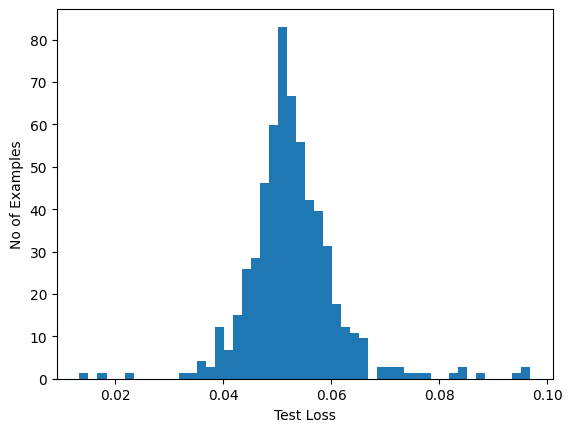

In [68]:
test_loss=tf.keras.losses.mae(reconstructions,anomalous_test_data).numpy()
plt.hist(test_loss,bins=50,density=True)
plt.xlabel("Test Loss")
plt.ylabel("No of Examples")
plt.show()

In [69]:
#如果异构误差大于阈值那么将这个ECG分类为异常
def predict(model,data,threshold):
    reconstructions=model(data)
    loss=tf.keras.losses.mae(reconstructions,data)
    return tf.math.less(loss,threshold)#返回loss小于threshold的真值
def print_stats(prediction,labels):
    print("Accuracy={}".format(accuracy_score(labels,preds)))
    print("Precision={}".format(precision_score(labels,preds)))
    print("Recall={}".format(recall_score(labels,preds)))

In [70]:
preds=predict(autoencoder,test_data,threshold)
print_stats(preds,test_labels)

Accuracy=0.946
Precision=0.9922178988326849
Recall=0.9107142857142857


In [72]:
autoencoder.save('my_model', save_format='tf')


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [75]:
import numpy as np
import requests
import json

# Generate normal and abnormal ECG data. Replace these with actual ECG data.
normal_ecg_data = np.random.rand(140).tolist()  # Normal ECG data
abnormal_ecg_data = np.random.rand(140).tolist()  # Abnormal ECG data

print(normal_ecg_data)
print(abnormal_ecg_data)

[0.18018420508016297, 0.3280865840728837, 0.23049353519804816, 0.16649289251229804, 0.870900965516247, 0.9063048343862687, 0.6488038237641581, 0.25642616133111973, 0.9274253559147442, 0.9495866917833552, 0.251292470522272, 0.5423624049390868, 0.7207360464816162, 0.9201144492717416, 0.6131840685816111, 0.4230621511145294, 0.943621630901697, 0.001736956233699849, 0.6630894761442404, 0.19626913557651693, 0.6567948255954243, 0.9037639983322002, 0.7615270942535642, 0.6306681090599309, 0.13494650002963704, 0.8250284013814662, 0.10102335403072349, 0.8516008388499441, 0.7718121655999336, 0.45813185714398696, 0.25656253383848493, 0.954628144176438, 0.5956199819932702, 0.6364509846608732, 0.06147641326642961, 0.6895833634263819, 0.6080388268471362, 0.6875301433983217, 0.895733372238446, 0.9272922987932843, 0.3080620464435583, 0.8285261425313838, 0.9936138648287652, 0.3435191269792276, 0.14903097883599226, 0.5354642023058429, 0.6385622900363964, 0.834386834051971, 0.5120706667881899, 0.6764975177

: 